In [1]:
!pip install torch==2.0.1 pytorch-lightning==2.0.2 pytorch_forecasting==1.0.0 torchaudio==2.0.2 torchdata==0.6.1 torchtext==0.15.2 torchvision==0.15.2 optuna==3.4

In [2]:
!pip show pytorch_forecasting

Name: pytorch-forecasting
Version: 1.0.0
Summary: Forecasting timeseries with PyTorch - dataloaders, normalizers, metrics and models
Home-page: https://pytorch-forecasting.readthedocs.io
Author: Jan Beitner
Author-email: 
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: fastapi, lightning, matplotlib, optuna, pandas, pytorch-optimizer, scikit-learn, scipy, statsmodels, torch
Required-by: 


In [3]:
!pip show torch

Name: torch
Version: 2.0.1
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, jinja2, networkx, nvidia-cublas-cu11, nvidia-cuda-cupti-cu11, nvidia-cuda-nvrtc-cu11, nvidia-cuda-runtime-cu11, nvidia-cudnn-cu11, nvidia-cufft-cu11, nvidia-curand-cu11, nvidia-cusolver-cu11, nvidia-cusparse-cu11, nvidia-nccl-cu11, nvidia-nvtx-cu11, sympy, triton, typing-extensions
Required-by: accelerate, fastai, lightning, pytorch-forecasting, pytorch-lightning, pytorch_optimizer, timm, torchaudio, torchdata, torchmetrics, torchtext, torchvision, triton


In [4]:
!pip show pytorch-lightning

Name: pytorch-lightning
Version: 2.0.2
Summary: PyTorch Lightning is the lightweight PyTorch wrapper for ML researchers. Scale your models. Write less boilerplate.
Home-page: https://github.com/Lightning-AI/lightning
Author: Lightning AI et al.
Author-email: pytorch@lightning.ai
License: Apache-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: fsspec, lightning-utilities, numpy, packaging, PyYAML, torch, torchmetrics, tqdm, typing-extensions
Required-by: lightning


In [6]:
import warnings
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorboard as tb
#tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [7]:
import logging
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

# this message disables the following outputs:
# INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
# INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Extented Time-Series Format

In [9]:
sample_data = pd.DataFrame(
    dict(
        time_idx=np.tile(np.arange(6), 3),
        target=np.array([0,1,2,3,4,5,20,21,22,23,24,25,40,41,42,43,44,45]),
        group=np.repeat(np.arange(3), 6),
        holidays = np.tile(['X','Black Friday', 'X','Christmas','X', 'X'],3),
    )
)
sample_data

,time_idx,target,group,holidays
0,0,0,0,X
1,1,1,0,Black Friday
2,2,2,0,X
3,3,3,0,Christmas
4,4,4,0,X
5,5,5,0,X
6,0,20,1,X
7,1,21,1,Black Friday
8,2,22,1,X
9,3,23,1,Christmas


In [10]:
# create the time-series dataset from the pandas df
dataset = TimeSeriesDataSet(
    sample_data,
    group_ids=["group"],
    target="target",
    time_idx="time_idx",
    max_encoder_length=2,
    max_prediction_length=3,
    time_varying_unknown_reals=["target"],
    static_categoricals=["holidays"],
    target_normalizer=None
)

# pass the dataset to a dataloader
dataloader = dataset.to_dataloader(batch_size=1)

#load the first batch
x, y = next(iter(dataloader))
print(x['encoder_target'])
print(x['groups'])
print('\n')
print(x['decoder_target'])

tensor([[0., 1.]])
tensor([[0]])


tensor([[2., 3., 4.]])


# Energy Demand Forecasting with Temporal Fusion Transformer

### Download the dataset

In [11]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip
!unzip LD2011_2014.txt.zip

--2024-10-23 15:11:32--  https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘LD2011_2014.txt.zip’

LD2011_2014.txt.zip     [    <=>             ] 249.23M  22.9MB/s    in 7.3s    

2024-10-23 15:11:40 (34.1 MB/s) - ‘LD2011_2014.txt.zip’ saved [261335609]

Archive:  LD2011_2014.txt.zip
  inflating: LD2011_2014.txt         
   creating: __MACOSX/
  inflating: __MACOSX/._LD2011_2014.txt  


### Data Preprocessing

In [12]:
data = pd.read_csv('LD2011_2014.txt', index_col=0, sep=';', decimal=',')
data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)
data.head(5)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
data = data.resample('1h').mean().replace(0., np.nan)
earliest_time = data.index.min()
df=data[['MT_002',	'MT_004',	'MT_005',	'MT_006',	'MT_008' ]]

In [14]:
df_list = []

for label in df:

    ts = df[label]

    start_date = min(ts.fillna(method='ffill').dropna().index)
    end_date = max(ts.fillna(method='bfill').dropna().index)

    active_range = (ts.index >= start_date) & (ts.index <= end_date)
    ts = ts[active_range].fillna(0.)

    tmp = pd.DataFrame({'power_usage': ts})
    date = tmp.index

    tmp['hours_from_start'] = (date - earliest_time).seconds / 60 / 60 + (date - earliest_time).days * 24
    tmp['hours_from_start'] = tmp['hours_from_start'].astype('int')

    tmp['days_from_start'] = (date - earliest_time).days
    tmp['date'] = date
    tmp['consumer_id'] = label
    tmp['hour'] = date.hour
    tmp['day'] = date.day
    tmp['day_of_week'] = date.dayofweek
    tmp['month'] = date.month

    #stack all time series vertically
    df_list.append(tmp)

time_df = pd.concat(df_list).reset_index(drop=True)

# match results in the original paper
time_df = time_df[(time_df['days_from_start'] >= 1096)
                & (time_df['days_from_start'] < 1346)].copy()

<ipython-input-14-3e99b1f7f190>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  start_date = min(ts.fillna(method='ffill').dropna().index)
<ipython-input-14-3e99b1f7f190>:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  end_date = max(ts.fillna(method='bfill').dropna().index)
<ipython-input-14-3e99b1f7f190>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  start_date = min(ts.fillna(method='ffill').dropna().index)
<ipython-input-14-3e99b1f7f190>:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  end_date = max(ts.fillna(method='bfill').dropna().index)
<ipython-input-14-3e99b1f7f190>:7: FutureWarning: Series.fillna with 'method' is depreca

In [15]:
time_df

,power_usage,hours_from_start,days_from_start,date,consumer_id,hour,day,day_of_week,month
17544,24.004267,26304,1096,2014-01-01 00:00:00,MT_002,0,1,2,1
17545,23.293030,26305,1096,2014-01-01 01:00:00,MT_002,1,1,2,1
17546,24.537696,26306,1096,2014-01-01 02:00:00,MT_002,2,1,2,1
17547,21.870555,26307,1096,2014-01-01 03:00:00,MT_002,3,1,2,1
17548,22.226174,26308,1096,2014-01-01 04:00:00,MT_002,4,1,2,1
...,...,...,...,...,...,...,...,...,...
128759,249.158249,32299,1345,2014-09-07 19:00:00,MT_008,19,7,6,9
128760,303.030303,32300,1345,2014-09-07 20:00:00,MT_008,20,7,6,9
128761,306.397306,32301,1345,2014-09-07 21:00:00,MT_008,21,7,6,9
128762,279.461279,32302,1345,2014-09-07 22:00:00,MT_008,22,7,6,9


### EDA

In [16]:
time_df.query(" hours_from_start==26304")

,power_usage,hours_from_start,days_from_start,date,consumer_id,hour,day,day_of_week,month
17544,24.004267,26304,1096,2014-01-01,MT_002,0,1,2,1
43849,148.882114,26304,1096,2014-01-01,MT_004,0,1,2,1
70154,75.609756,26304,1096,2014-01-01,MT_005,0,1,2,1
96459,276.041667,26304,1096,2014-01-01,MT_006,0,1,2,1
122764,247.474747,26304,1096,2014-01-01,MT_008,0,1,2,1


In [17]:
time_df[['consumer_id','power_usage']].groupby('consumer_id').mean()

,power_usage
consumer_id,
MT_002,27.472588
MT_004,120.573001
MT_005,50.958384
MT_006,183.387773
MT_008,248.884259


Text(0.5, 1.0, 'Power usage of consumers')

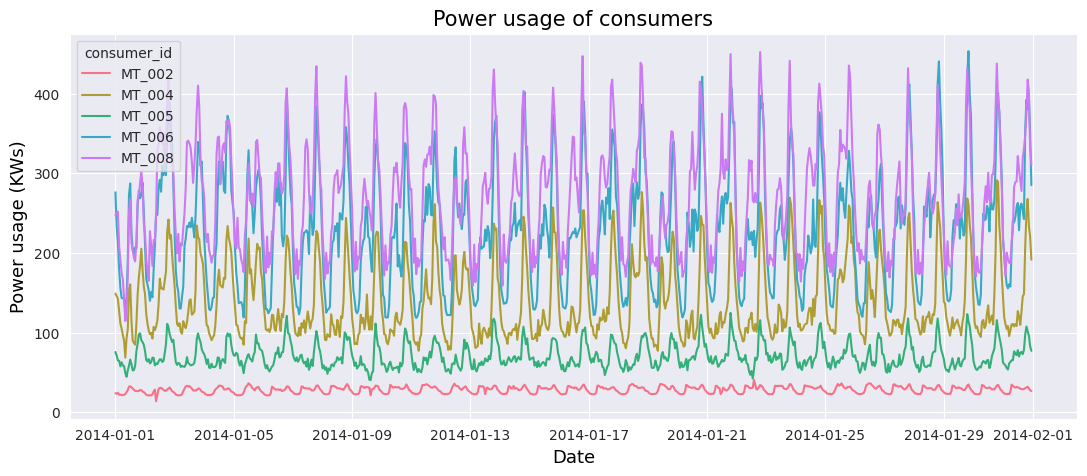

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

#plt.rcParams.update(plt.rcParamsDefault)
sns.set_style('darkgrid')
sns.color_palette("tab10")

fig, ax = plt.subplots(figsize=(13, 5))

sns.lineplot(data=time_df[time_df['month'] == 1],
             x='date',
             y='power_usage',
             hue='consumer_id',
             legend='full',
             palette='husl').set_title('Power usage per consumers')

ax.set_xlabel("Date", fontdict={"color":  "black", "size": 13} )
ax.set_ylabel("Power usage (KWs)", fontdict={"color":  "black", "size": 13})
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax.set_title(label = "Power usage of consumers", fontdict={"color":  "black", "size": 15})

### Data Preparation

In [ ]:
# So, we have 30,000 datapoints in total
#len(time_df)= 30000

#Each consumer has 30,000/5 =6,000 datapoints
# len(time_df.query( "consumer_id== 'MT_002' ")) = 60000

#### Next we move to split our data

# 29880 for training data
# 120 for validation data = 5 consumers * 24 hours =120

# So in the validation set, each consumer has one day of data

In [2]:
#Hyperparameters
#batch size=64
#number heads=4, hidden sizes=160, lr=0.001, gr_clip=0.1

max_prediction_length = 24
max_encoder_length = 7*24
training_cutoff = time_df["hours_from_start"].max() - max_prediction_length

training = TimeSeriesDataSet(
    time_df[lambda x: x.hours_from_start <= training_cutoff],
    time_idx="hours_from_start",
    target="power_usage",
    group_ids=["consumer_id"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["consumer_id"],
    time_varying_known_reals=["hours_from_start","day","day_of_week", "month", 'hour'],
    time_varying_unknown_reals=['power_usage'],
    target_normalizer=GroupNormalizer(
        groups=["consumer_id"], transformation="softplus"
    ),  # we normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)


validation = TimeSeriesDataSet.from_dataset(training, time_df, predict=True, stop_randomization=True)

# create dataloaders for  our model
batch_size = 64
# if you have a strong GPU, feel free to increase the number of workers
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

NameError: name 'time_df' is not defined

In [1]:
time_df['consumer_id'].value_counts()

NameError: name 'time_df' is not defined

The **training.index** and **validation.index** show how our training and validation instances are sliced.
For example, **sequence_length**= **max_encoder_length** + **max_prediction_length**

In [ ]:
training.index

In [ ]:
validation.index

### Baseline Model

In [ ]:
## for pytorch-forecasting < 1.0

actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

In [ ]:
## for pytorch-forecasting >= 1.0
## requires to("cuda") to work

#actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)]).to("cuda")
#baseline_predictions = Baseline().predict(val_dataloader)
#(actuals - baseline_predictions).abs().mean().item()

In [ ]:
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

In [ ]:
## the default option for pytorch-forecasting >= 1.0

baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

### Build TFT model

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs=45,
    accelerator='gpu',
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

In [ ]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

### Save The Model

In [ ]:
#zip and download the model
!zip  -r model.zip lightning_logs/lightning_logs/version_0/*

In [ ]:
#load our saved model again
!unzip model.zip
best_model_path='lightning_logs/lightning_logs/version_0/checkpoints/epoch=11-step=5698.ckpt'
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

### Training and Validation curves on Tensorboard

In [ ]:
# Start tensorboard
%load_ext tensorboard
%tensorboard --logdir lightning_logs

## Evaluate on Training data

In [ ]:
train_evaluation_dataloader = training.to_dataloader(train=False, batch_size=batch_size, num_workers=8)

actuals = torch.cat([y[0] for x, y in iter(train_evaluation_dataloader)]).to("cuda")
predictions = best_tft.predict(train_evaluation_dataloader)

#average p50 loss overall
print((actuals - predictions).abs().nanmean().item())
# baseline score on training data is 32.30066680908203

In [ ]:
#### The reason we use np.nanmean instead of np.mean() is that some predictions are NaN
# this is because of  encoder_length // 2 + target_length

## we will eplain this below:

In [ ]:
training_cutoff

In [ ]:
#Total datapoints for training
time_df[time_df["hours_from_start"] <= training_cutoff]

In [ ]:
#Total datapoints for validation
time_df[time_df["hours_from_start"] > training_cutoff]

In [ ]:
120/5

In [ ]:
# So, we have 30,000 datapoints in total
#len(time_df)= 30000

#Each consumer has 30,000/5 =6,000 datapoints
# len(time_df.query( "consumer_id== 'MT_002' ")) = 60000

#### Next we move to split our data

# 29880 for training data
# 120 for validation data = 5 consumers * 24 hours =120

# So in the validation set, each consumer has one day of data

In [ ]:
#Let's find out how many datapoints does the first consumer has in the training set:


time_df[time_df["hours_from_start"] <= training_cutoff].query( "consumer_id== 'MT_002' ")

In [ ]:
#This checks out because

#total_data for a consumer - validation data for a consumer
assert (6000 - 24 == 5976)

In [ ]:
#5976 - 5869

In [ ]:
training.index.query(" sequence_id ==0")

In [ ]:
validation.index.query(" sequence_id ==0")

In [ ]:
## Validation[0] describes the first slice. The slice has 192 datapoints
# which is 168 from training data as lookback window and 24 the data to predict. (168 + 24) = 192

In [ ]:
validation[0]

In [ ]:
actuals.shape

In [ ]:
predictions.shape

In [ ]:
actuals

In [ ]:
predictions

In [ ]:
#find where nan in predictions appear?

nan_rows = torch.isnan(predictions).any(dim=1)

# Get the indices of rows with NaN values
nan_row_indices = torch.nonzero(nan_rows)

# Print the indices of rows with NaN values
print(nan_row_indices)

In [ ]:
#first time nan appears
predictions[5869]

In [ ]:
# last time nan appears
predictions[5891]

In [ ]:
# next series starts
predictions[5892]

In [ ]:
## why the cuttof point is 5891?

#Becuase: encoder_length // 2 + target_length

7*24 // 2 + 24

In [ ]:
len(training.index.query(" sequence_id ==0"))

In [ ]:
#total_size_of_training_index for consumer MT_002 - 108

#5999 - 108 = 5891 (5999 becuase 1 slice out of 6000 is assigned to validation)

len(training.index.query(" sequence_id ==0")) - 108

In [ ]:
#notice the cuttoff point, in that slice, encode_lenth= 84 and predictions =1
training[5891]

In [ ]:
# the sequence length is 85
training.index.loc[5891]

In [ ]:
##### Rest of the notes, just experiments

In [ ]:
training[5801]

In [ ]:
training[29550]

In [ ]:
training.index.query(" sequence_id ==0")

In [ ]:
training.index

In [ ]:
training.index.loc[29884]

In [ ]:
training[0]

In [ ]:
training[5782]

In [ ]:
6000 - 5891

In [ ]:
predictions[5869]

In [ ]:
time_df.query(" consumer_id == 'MT_002' ")

In [ ]:
## unfortunately the pytorch-forecasting==1.0 new way does not work for evaluating traing loss

train_evaluation_dataloader = training.to_dataloader(train=False, batch_size=batch_size, num_workers=8)

#predictions = best_tft.predict(train_evaluation_dataloader, return_y=True, trainer_kwargs=dict(accelerator="gpu"))
#MAE()(predictions.output, predictions.y)

#actuals = torch.cat([y[0] for x, y in iter(train_evaluation_dataloader)])
#predictions = best_deepvar.predict(train_evaluation_dataloader)

#average p50 loss overall
#print((actuals - predictions).abs().mean().item())
# baseline score on training data is 32.30066680908203

### Evaluate on validation data and plot results

In [ ]:
## using the old pytorch-forecasting method (<1.0)

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to('cuda')
predictions = best_tft.predict(val_dataloader)

#average p50 loss overall
print((actuals - predictions).abs().mean().item())
#average p50 loss per time series
print((actuals - predictions).abs().mean(axis=1))

In [ ]:
## using the new pytorch-forecasting method (1.0)

predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="gpu"))
MAE()(predictions.output, predictions.y)

In [ ]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

for idx in range(5):  # plot all 5 consumers
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=QuantileLoss(),ax=ax)

In [ ]:
#Take a look at what the raw_predictions variable contains

raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)
print(raw_predictions._fields)
#('output', 'x', 'index', 'decoder_lengths', 'y')

print('\n')
print(raw_predictions.output._fields)
# ('prediction',
# 'encoder_attention',
# 'decoder_attention',
# 'static_variables',
# 'encoder_variables',
# 'decoder_variables',
# 'decoder_lengths',
# 'encoder_lengths')

print('\n')
print(raw_predictions.output.prediction.shape)
#torch.Size([5, 24, 7])

# We get predictions of 5 time-series for 24 days.
# For each day we get 7 predictions - these are the 7 quantiles:
#[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
# We are mostly interested in the 4th quantile which represents, let's say, the 'median loss'
# fyi, although docs use the term quantiles, the most accurate term are percentiles

### Evaluate on a specific Time-Series

We can also evaluate for a specific time series explicitly. Since we already tried on the validation set, we can try on the training set

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

raw_prediction= best_tft.predict(
    training.filter(lambda x: (x.consumer_id == "MT_004") & (x.time_idx_first_prediction == 26512)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0, ax=ax);

In [ ]:
26304 + 168//2

In [ ]:
#the minimum time index that we can use is 26388
# small bug on new pytorch forecasting lib (1.0)


raw_prediction = best_tft.predict(
    training.filter(lambda x: (x.consumer_id == "MT_004") & (x.time_idx_first_prediction == 26388)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0);

In [ ]:
#old pytorch forecasting lib has no error
#the minimum time index that we can use is 26388
fig, ax = plt.subplots(figsize=(10, 5))

raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.consumer_id == "MT_004") & (x.time_idx_first_prediction == 26388)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0, ax=ax);

In [ ]:
#this is equal to the 5-multiFigure  plot for idx=1 (the second consumer MT_004)
fig, ax = plt.subplots(figsize=(10, 5))

raw_prediction, x = best_tft.predict(
    validation.filter(lambda x: (x.consumer_id == "MT_004")),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0, ax=ax);

In [ ]:
#### plots a new model here:
# we prove that for idx=1 (the second consumer MT_004) we get the same plot in the  5-multiFigure  plot
# notice the loss values in the digarm

#also
# add_loss_to_title=QuantileLoss() is the same as add_loss_to_title=True
# hence the default loss on the plot title IS the quantileloss
# https://medium.com/@nikoskafritsas/thank-you-you-always-ask-the-good-questions-5fa2db1222ed

In [ ]:
#repeat by adding QuantileLoss
#this is equal to the 5-multiFigure  plot for idx=1 (the second consumer MT_004)
fig, ax = plt.subplots(figsize=(10, 5))

raw_prediction = best_tft.predict(
    validation.filter(lambda x: (x.consumer_id == "MT_004")),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0, add_loss_to_title=QuantileLoss(),ax=ax);

In [ ]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

for idx in range(5):  # plot all 5 consumers
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=QuantileLoss(),ax=ax)

## Test on new Data

In [ ]:
#encoder data is the last lookback window: we get the last 1 week (168 datapoints) for all 5 consumers = 840 total datapoints
encoder_data = time_df[lambda x: x.hours_from_start > x.hours_from_start.max() - max_encoder_length]
last_data = time_df[lambda x: x.hours_from_start == x.hours_from_start.max()]

#decoder_data is the new dataframe for which we will create predictions.
#decoder_data df should be max_prediction_length* consumers = 24*5=120 datapoints long : 24 datapoints for each cosnumer
#we create it by repeating the last hourly observation of every consumer 24 times since we do not really have new test data
#and later we fix the columns
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.Hour(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

#fix the new columns
decoder_data["hours_from_start"] = (decoder_data["date"] - earliest_time).dt.seconds / 60 / 60 + (decoder_data["date"] - earliest_time).dt.days * 24
decoder_data['hours_from_start'] = decoder_data['hours_from_start'].astype('int')
decoder_data["hours_from_start"] += encoder_data["hours_from_start"].max() + 1 - decoder_data["hours_from_start"].min()

decoder_data["month"] = decoder_data["date"].dt.month.astype(np.int64)
decoder_data["hour"] = decoder_data["date"].dt.hour.astype(np.int64)
decoder_data["day"] = decoder_data["date"].dt.day.astype(np.int64)
decoder_data["day_of_week"] = decoder_data["date"].dt.dayofweek.astype(np.int64)

new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

#create out-of-sample predictions for MT_002
new_prediction_data=new_prediction_data.query(" consumer_id == 'MT_002'")
new_raw_predictions = best_tft.predict(new_prediction_data, mode="raw", return_x=True)
best_tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=0, show_future_observed=False, ax=ax);


# Feature Importances

In [ ]:
raw_predictions= best_tft.predict(val_dataloader, mode="raw", return_x=True)
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

### Extreme Event Detection

In [ ]:
#Analysis on the training set
predictions = best_tft.predict(train_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [ ]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

## Hyperparameter Tuning

In [ ]:
# create a new study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=1,
    max_epochs=1,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(30, 128),
    hidden_continuous_size_range=(30, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False
)

# save study results
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# print best hyperparameters
print(study.best_trial.params)

In [ ]:
!pip show pytorch_forecasting

In [ ]:
# Bug for __init__() got an unexpected keyword argument 'weights_summary'

# This bug occurs if pip installs the 0.10.1 version of pytorch-forecasting

# To fix this either install the 0.10.3+ repo from github directly
#or
# go in Colab here: go to /usr/local/lib/python3.7/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py
# and replace this line: weights_summary=[None, "top"][optuna_verbose < optuna.logging.INFO],
# with this:
# enable_model_summary=[False, True][optuna_verbose < optuna.logging.INFO]
# then restart colab runtime for changes to take effect

